<a href="https://colab.research.google.com/github/PierreSylvain/covid-chestxray-detector/blob/master/covid_chestxray_detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Load images

In [2]:
# Load zipped  images directory and decompress into data folder
!wget https://filedn.com/lvsbt6znCCkhw76TPAmL9PL/data.zip
!unzip -q -o /content/data.zip
!ls /content/data/train 

--2020-05-30 08:46:07--  https://filedn.com/lvsbt6znCCkhw76TPAmL9PL/data.zip
Resolving filedn.com (filedn.com)... 74.120.9.25
Connecting to filedn.com (filedn.com)|74.120.9.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 166593773 (159M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>] 158.88M  44.9MB/s    in 6.5s    

2020-05-30 08:46:14 (24.5 MB/s) - ‘data.zip’ saved [166593773/166593773]

0_normal  1_covid


# Load libraries

In [0]:
# Load libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
#import random

# Keras
#import keras
#from keras.utils import to_categorical
#from keras.models import Sequential

#from keras.layers import Conv2D
#from keras.layers import MaxPooling2D
from keras.layers import Dense
#from keras.layers import Activation
from keras.layers import Flatten
#from keras.layers import MaxPool2D
#from keras.layers import Dense, GlobalAveragePooling2D
from keras.layers import AveragePooling2D
from keras.layers import Dropout


from keras.optimizers import SGD
#from keras.optimizers import Adam

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Model
#from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
#from tensorflow.keras.applications.inception_v3 import InceptionV3

#from keras.callbacks import ModelCheckpoint, EarlyStopping

import warnings
warnings.filterwarnings('ignore')


# Create model

In [0]:
# Create data generator
# One for train data and other for val and test
def data_generator():
  datagen = ImageDataGenerator(
    rescale= 1 / 255.0,
    rotation_range=15,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    fill_mode="nearest")  
  return  datagen

def data_generator_basic():
  datagen = ImageDataGenerator(rescale= 1 / 255.0)  
  return  datagen 

In [0]:
# VGG19 Model
def vgg_model(image_width, image_height):
  vgg_model = VGG19(include_top=False, input_shape=(image_width, image_height, 3))
  
  for layer in vgg_model.layers[:-3]:
    layer.trainable = False

  avg = AveragePooling2D(pool_size=(4, 4))(vgg_model.layers[-1].output)
  flat1 = Flatten()(avg)
  
  class1 = Dense(128, activation='relu', kernel_initializer='he_uniform')(flat1) 
  dropout1 = Dropout(0.5)(class1)  
  
  output = Dense(1, activation='sigmoid')(dropout1)
  
  model = Model(inputs=vgg_model.inputs, outputs=output)
  opt = SGD(lr=0.001, momentum=0.9)  
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

  #model.summary()
  return model

# Train model

In [22]:
# Train model
nb_epochs = 5
image_width = 320
image_height = 382
train_dir = "/content/data/train"
test_dir = "/content/data/test"

model = vgg_model(image_width,image_height)

datagen = data_generator()
datagen_basic = data_generator_basic()

# Prepare
train = datagen.flow_from_directory(train_dir, class_mode='binary', batch_size=64, target_size=(image_width, image_height))
val = datagen_basic.flow_from_directory( test_dir,  class_mode='binary', batch_size=64, target_size=(image_width, image_height))

# Train model
history = model.fit_generator(
    train, 
    steps_per_epoch=len(train), 
    validation_data=val, 
    validation_steps=len(val), 
    epochs=nb_epochs,    
    verbose=1)

# Save model 
model.save('VGG-covid19.h5')

# Evaluate
_, acc = model.evaluate_generator(val, steps=len(val), verbose=1)
print('Model accuracy %.3f' % (acc * 100.0))


Found 216 images belonging to 2 classes.
Found 55 images belonging to 2 classes.
Epoch 1/5
4/4 [==============================] - 18s 4s/step - loss: 0.7405 - accuracy: 0.5741 - val_loss: 0.6585 - val_accuracy: 0.6727
Epoch 2/5
4/4 [==============================] - 11s 3s/step - loss: 0.7587 - accuracy: 0.5463 - val_loss: 0.6356 - val_accuracy: 0.7091
Epoch 3/5
4/4 [==============================] - 12s 3s/step - loss: 0.7168 - accuracy: 0.5926 - val_loss: 0.6460 - val_accuracy: 0.7273
Epoch 4/5
4/4 [==============================] - 12s 3s/step - loss: 0.6659 - accuracy: 0.6296 - val_loss: 0.5743 - val_accuracy: 0.7273
Epoch 5/5
1/1 [==============================] - 5s 5s/step
Model accuracy 80.000


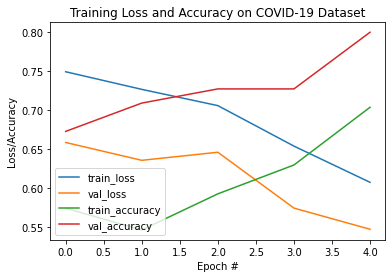

In [25]:
# Training Loss and Accuracy on COVID-19 Dataset
plt.figure()
plt.plot(np.arange(0, nb_epochs), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, nb_epochs), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, nb_epochs), history.history["accuracy"], label="train_accuracy")
plt.plot(np.arange(0, nb_epochs), history.history["val_accuracy"], label="val_accuracy")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()